# Подготока

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 30.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import lightgbm as lgb
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from scipy import stats, linalg
import shap
from sklearn.cluster import DBSCAN
import seaborn as sns

# Загрузка данных

In [ ]:
oil_table = pd.read_csv('/content/drive/MyDrive/oil/train.csv', parse_dates=['datetime'])
oil_table.head()

,datetime,Номер скважины,Дебит нефти,Давление забойное,x,y,Объем жидкости,Объем нефти,Активная мощность (ТМ),Время работы (ТМ),Газовый фактор рабочий (ТМ),Давление буферное,Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),Дебит газа (ТМ),Дебит газа попутного,Дебит жидкости (ТМ),Коэффициент мощности (ТМ)
0,1990-08-01,0,19.939,NaN,18670.86,5714.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-08-02,0,19.939,39.064454,18670.86,5714.86,NaN,NaN,50.851351,9.600833,NaN,NaN,33.913336,39.064454,1.887872,30.293676,3843.746667,24.25,24.250000,98.534314
2,1990-08-03,0,21.172,39.064487,18670.86,5714.86,NaN,NaN,52.353846,NaN,NaN,NaN,33.806090,39.064487,1.885714,30.261774,3900.955000,25.75,25.833333,99.139785
3,1990-08-04,0,22.529,38.965297,18670.86,5714.86,NaN,NaN,51.242424,9.600000,NaN,NaN,33.695717,38.965297,1.875851,30.212768,3874.505000,27.40,27.933333,98.744318
4,1990-08-05,0,22.529,38.766822,18670.86,5714.86,NaN,NaN,50.910256,9.563889,NaN,NaN,33.695717,38.766822,1.873163,30.109119,3853.696667,27.40,27.400000,98.419689


# Feature Engineering

In [ ]:
oil_table['Процент дебита нефти в жидкости'] = oil_table['Дебит нефти'] / (oil_table['Дебит нефти'] + oil_table['Дебит жидкости (ТМ)'])
oil_table['Отношение дебита нефти к жидкости'] = oil_table['Дебит нефти'] / oil_table['Дебит жидкости (ТМ)']
oil_table['Отношение дебита нефти к газу'] = oil_table['Дебит нефти'] / oil_table['Дебит газа (ТМ)']
oil_table['Процент дебита попутного газа к нефте'] = oil_table['Дебит газа попутного'] / (oil_table['Дебит газа попутного'] + oil_table['Дебит нефти'])
oil_table['Отношение линейного к забойному нд'] = oil_table['Давление линейное (ТМ)'] / oil_table['Давление забойное от Hд']
oil_table['Отношение линейного к забойному'] = oil_table['Давление линейное (ТМ)'] / oil_table['Давление забойное']
oil_table['Отношение линейного к эцн'] = oil_table['Давление линейное (ТМ)'] / oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Отношение забойного нд к забойному'] = oil_table['Давление забойное от Hд'] / oil_table['Давление забойное']
oil_table['Отношение забойного нд к эцн'] = oil_table['Давление забойное от Hд'] / oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Отношение забойного к эцн'] = oil_table['Давление забойное'] / oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Полная мощность'] = oil_table['Активная мощность (ТМ)'] / oil_table['Коэффициент мощности (ТМ)']
oil_table['Дебит нефти на активную мощность'] = oil_table['Дебит нефти'] / oil_table['Активная мощность (ТМ)']
oil_table['Дебит нефти на коэфицент мощности'] = oil_table['Дебит нефти'] / oil_table['Коэффициент мощности (ТМ)']
oil_table['Продуктивность (Дебит нефти на время)'] = oil_table['Дебит нефти'] / oil_table['Время работы (ТМ)']
oil_table['Продуктивность (Дебит жидкости на время)'] = oil_table['Дебит жидкости (ТМ)'] / oil_table['Время работы (ТМ)']
oil_table['Работа (Дебит газа)'] = oil_table['Дебит газа (ТМ)'] * oil_table['Время работы (ТМ)']
oil_table['Работа (Дебит жидкости)'] = oil_table['Дебит жидкости (ТМ)'] * oil_table['Время работы (ТМ)']
oil_table['Разность давления забойного и входа'] = oil_table['Давление забойное'] - oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Разность давления нд и входа'] = oil_table['Давление забойное от Hд'] - oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Разность давления линейного и входа'] = oil_table['Давление линейное (ТМ)'] - oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Отношение давления забойного и входа'] = oil_table['Давление забойное'] - oil_table['Давление на входе ЭЦН (ТМ)']
oil_table['Продуктивность (Дебит нефти к давлению забойному)'] = oil_table['Дебит нефти'] / oil_table['Давление забойное']
oil_table['Продуктивность (Дебит нефти к давлению нд)'] = oil_table['Дебит нефти'] / oil_table['Давление забойное от Hд']
oil_table['Продуктивность (Дебит нефти к разности забойного и входа)'] = oil_table['Дебит нефти'] / oil_table['Разность давления забойного и входа']
oil_table['Продуктивность (Дебит нефти к разности забойного и линейного)'] = oil_table['Дебит нефти'] / (oil_table['Давление забойное'] - oil_table['Давление линейное (ТМ)'])
oil_table['Продуктивность (Дебит нефти к разности забойного и нд)'] = oil_table['Дебит нефти'] / (oil_table['Давление забойное'] - oil_table['Давление забойное от Hд'] + 1e-5)
oil_table['Продуктивность (Дебит нефти к разности нд и линейного)'] = oil_table['Дебит нефти'] / (oil_table['Давление забойное от Hд'] - oil_table['Давление линейное (ТМ)'])
oil_table['Продуктивность (Дебит нефти к разности нд и входа)'] = oil_table['Дебит нефти'] / oil_table['Разность давления нд и входа']
oil_table['Продуктивность (Дебит нефти к разности линейного и входа)'] = oil_table['Дебит нефти'] / oil_table['Разность давления линейного и входа']

In [ ]:
time_series_table = pd.pivot_table(oil_table, index=['datetime'], columns=['Номер скважины'], aggfunc=np.sum).stack().stack().unstack(1).unstack(1)
time_series_table = time_series_table.append(pd.DataFrame(index=[time_series_table.index.max() + pd.DateOffset(i) for i in range(1, 75)], columns=time_series_table.columns))
time_series_table.index.name = 'datetime'
time_series_table

Номер скважины       0                                                      \
                       x        y Активная мощность (ТМ) Время работы (ТМ)   
datetime                                                                     
1990-08-01      18670.86  5714.86               0.000000          0.000000   
1990-08-02      18670.86  5714.86              50.851351          9.600833   
1990-08-03      18670.86  5714.86              52.353846          0.000000   
1990-08-04      18670.86  5714.86              51.242424          9.600000   
1990-08-05      18670.86  5714.86              50.910256          9.563889   
...                  ...      ...                    ...               ...   
1992-07-05           NaN      NaN                    NaN               NaN   
1992-07-06           NaN      NaN                    NaN               NaN   
1992-07-07           NaN      NaN                    NaN               NaN   
1992-07-08           NaN      NaN                    NaN               NaN   
1992-07-09           NaN      NaN                    NaN               NaN   

Номер скважины                                                \
               Газовый фактор рабочий (ТМ) Давление буферное   
datetime                                                       
1990-08-01                             0.0               0.0   
1990-08-02                             0.0               0.0   
1990-08-03                             0.0               0.0   
1990-08-04                             0.0               0.0   
1990-08-05                             0.0               0.0   
...                                    ...               ...   
1992-07-05                             NaN               NaN   
1992-07-06                             NaN               NaN   
1992-07-07                             NaN               NaN   
1992-07-08                             NaN               NaN   
1992-07-09                             NaN               NaN   

Номер скважины                                            \
               Давление забойное Давление забойное от Hд   
datetime                                                   
1990-08-01              0.000000                0.000000   
1990-08-02             39.064454               33.913336   
1990-08-03             39.064487               33.806090   
1990-08-04             38.965297               33.695717   
1990-08-05             38.766822               33.695717   
...                          ...                     ...   
1992-07-05                   NaN                     NaN   
1992-07-06                   NaN                     NaN   
1992-07-07                   NaN                     NaN   
1992-07-08                   NaN                     NaN   
1992-07-09                   NaN                     NaN   

Номер скважины                                                  ...  \
               Давление забойное от Pпр Давление линейное (ТМ)  ...   
datetime                                                        ...   
1990-08-01                     0.000000               0.000000  ...   
1990-08-02                    39.064454               1.887872  ...   
1990-08-03                    39.064487               1.885714  ...   
1990-08-04                    38.965297               1.875851  ...   
1990-08-05                    38.766822               1.873163  ...   
...                                 ...                    ...  ...   
1992-07-05                          NaN                    NaN  ...   
1992-07-06                          NaN                    NaN  ...   
1992-07-07                          NaN                    NaN  ...   
1992-07-08                          NaN                    NaN  ...   
1992-07-09                          NaN                    NaN  ...   

Номер скважины                      105                         \
               Давление забойное от Pпр Давление линейное (ТМ)   
datetime                                  

In [ ]:
map = oil_table.groupby('Номер скважины')[['x', 'y']].agg('mean')
map['cluster'] = DBSCAN(eps=1500, min_samples=2).fit_predict(map)

In [ ]:
def generate_features(ts):
  columns = set(ts.columns.get_level_values(1).unique())
  id_wells = ts.columns.get_level_values('Номер скважины').unique()
  for iter_oil_well in id_wells:
    ts.loc[:, (iter_oil_well, 'month')] = ts.index.to_series().dt.month
    ts.loc[:, (iter_oil_well, 'quarter')] = ts.index.to_series().dt.quarter
    for col in columns:
      ts.loc[:, (iter_oil_well, f'{col}_lag_90')] = ts[iter_oil_well][col].shift(90, freq="D")
    ts.loc[:, (iter_oil_well, 'Дебит нефти_lag_91')] = ts[iter_oil_well]['Дебит нефти_lag_90'].shift(1, freq="D")
    ts.loc[:, (iter_oil_well, 'Дебит нефти_mean_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_median_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).median()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_max_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).max()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_min_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).min()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_std_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).std()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_mean_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_median_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).median()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_min_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).min()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_max_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).max()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_std_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).std()
  ts = ts[sorted(ts.columns.to_list(), key=lambda x: (x[0], x[1]))]
  return ts.drop(columns - set(['Дебит нефти']), axis=1, level=1)

In [ ]:
def generate_features(ts):
  columns = set(ts.columns.get_level_values(1).unique())
  id_wells = ts.columns.get_level_values('Номер скважины').unique()
  for iter_oil_well in id_wells:
    ts.loc[:, (iter_oil_well, 'month')] = ts.index.to_series().dt.month
    ts.loc[:, (iter_oil_well, 'quarter')] = ts.index.to_series().dt.quarter
    #ts.loc[:, (iter_oil_well, 'cluster')] = map['cluster'].to_dict()[iter_oil_well]
    ts.loc[:, (iter_oil_well, 'x')] = map['x'].to_dict()[iter_oil_well]
    ts.loc[:, (iter_oil_well, 'y')] = map['y'].to_dict()[iter_oil_well]
    for col in columns:
      if col not in ['month', 'quarter', 'x', 'y']:  
        ts.loc[:, (iter_oil_well, col+'_lag_90')] = ts[iter_oil_well][col].shift(90, freq="D")
        ts.loc[:, (iter_oil_well, col+'_median_7')] = ts[iter_oil_well][col+'_lag_90'].rolling(7, min_periods=1).median()
        #ts.loc[:, (iter_oil_well, col+'_min_7')] = ts[iter_oil_well][col+'_lag_90'].rolling(7, min_periods=1).min()
        #ts.loc[:, (iter_oil_well, col+'_max_7')] = ts[iter_oil_well][col+'_lag_90'].rolling(7, min_periods=1).max()
    ts.loc[:, (iter_oil_well, 'Отношение забойного нд к эцн_mean_7')] = ts[iter_oil_well]['Отношение забойного нд к эцн'].shift(90, freq="D").rolling(7, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Отношение давления забойного и входа_mean_7')] = ts[iter_oil_well]['Отношение давления забойного и входа'].shift(90, freq="D").rolling(7, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_lag_91')] = ts[iter_oil_well]['Дебит нефти_lag_90'].shift(1, freq="D")
    ts.loc[:, (iter_oil_well, 'Дебит нефти_std_7')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(7, min_periods=1).std()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_mean_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_median_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).median()
    ts.loc[:, (iter_oil_well, 'Дебит нефти_min_30')] = ts[iter_oil_well]['Дебит нефти_lag_90'].rolling(30, min_periods=1).min()
    ts.loc[:, (iter_oil_well, 'Газовый фактор рабочий_std_30')] = ts[iter_oil_well]['Газовый фактор рабочий (ТМ)_lag_90'].rolling(30, min_periods=1).std()
    ts.loc[:, (iter_oil_well, 'Газовый фактор рабочий_mean_30')] = ts[iter_oil_well]['Газовый фактор рабочий (ТМ)_lag_90'].rolling(30, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Объем жидкости_std_30')] = ts[iter_oil_well]['Объем жидкости_lag_90'].rolling(30, min_periods=1).std()
    ts.loc[:, (iter_oil_well, 'Объем жидкости_mean_30')] = ts[iter_oil_well]['Объем жидкости_lag_90'].rolling(30, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Объем нефти_std_30')] = ts[iter_oil_well]['Объем нефти_lag_90'].rolling(30, min_periods=1).std()
    ts.loc[:, (iter_oil_well, 'Объем нефти_mean_30')] = ts[iter_oil_well]['Объем нефти_lag_90'].rolling(30, min_periods=1).mean()
    ts.loc[:, (iter_oil_well, 'Объем нефти_max_30')] = ts[iter_oil_well]['Объем нефти_lag_90'].rolling(30, min_periods=1).max()
  
  ts = ts[sorted(ts.columns.to_list(), key=lambda x: (x[0], x[1]))]
  return ts.drop(columns - set(['Дебит нефти']), axis=1, level=1)

In [ ]:
feature = generate_features(deepcopy(time_series_table)).stack(0)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=0)
feature[[f'pca_{i}'for i in range(5)]] = pca.fit_transform(feature.drop(['month', 'quarter', 'Дебит нефти'], axis=1).fillna(0).astype('float32'))

In [ ]:
feature['quarter'] = feature['quarter'].astype('category')
feature['month'] = feature['month'].astype('category')
feature_train = feature.dropna(subset=['Дебит нефти', 'Дебит нефти_lag_90'])
X = feature_train.drop(['Дебит нефти'], axis=1)
y = feature_train['Дебит нефти']

# EDA

In [ ]:
oil_table.isna().mean()*100

datetime                                                          0.000000
Номер скважины                                                    0.000000
Дебит нефти                                                       0.000000
Давление забойное                                                 3.545043
x                                                                 0.000000
y                                                                 0.000000
Объем жидкости                                                   94.838835
Объем нефти                                                      94.838835
Активная мощность (ТМ)                                            7.036463
Время работы (ТМ)                                                 5.453110
Газовый фактор рабочий (ТМ)                                      62.419566
Давление буферное                                                84.795043
Давление забойное от Hд                                           2.124047
Давление забойное от Pпр 

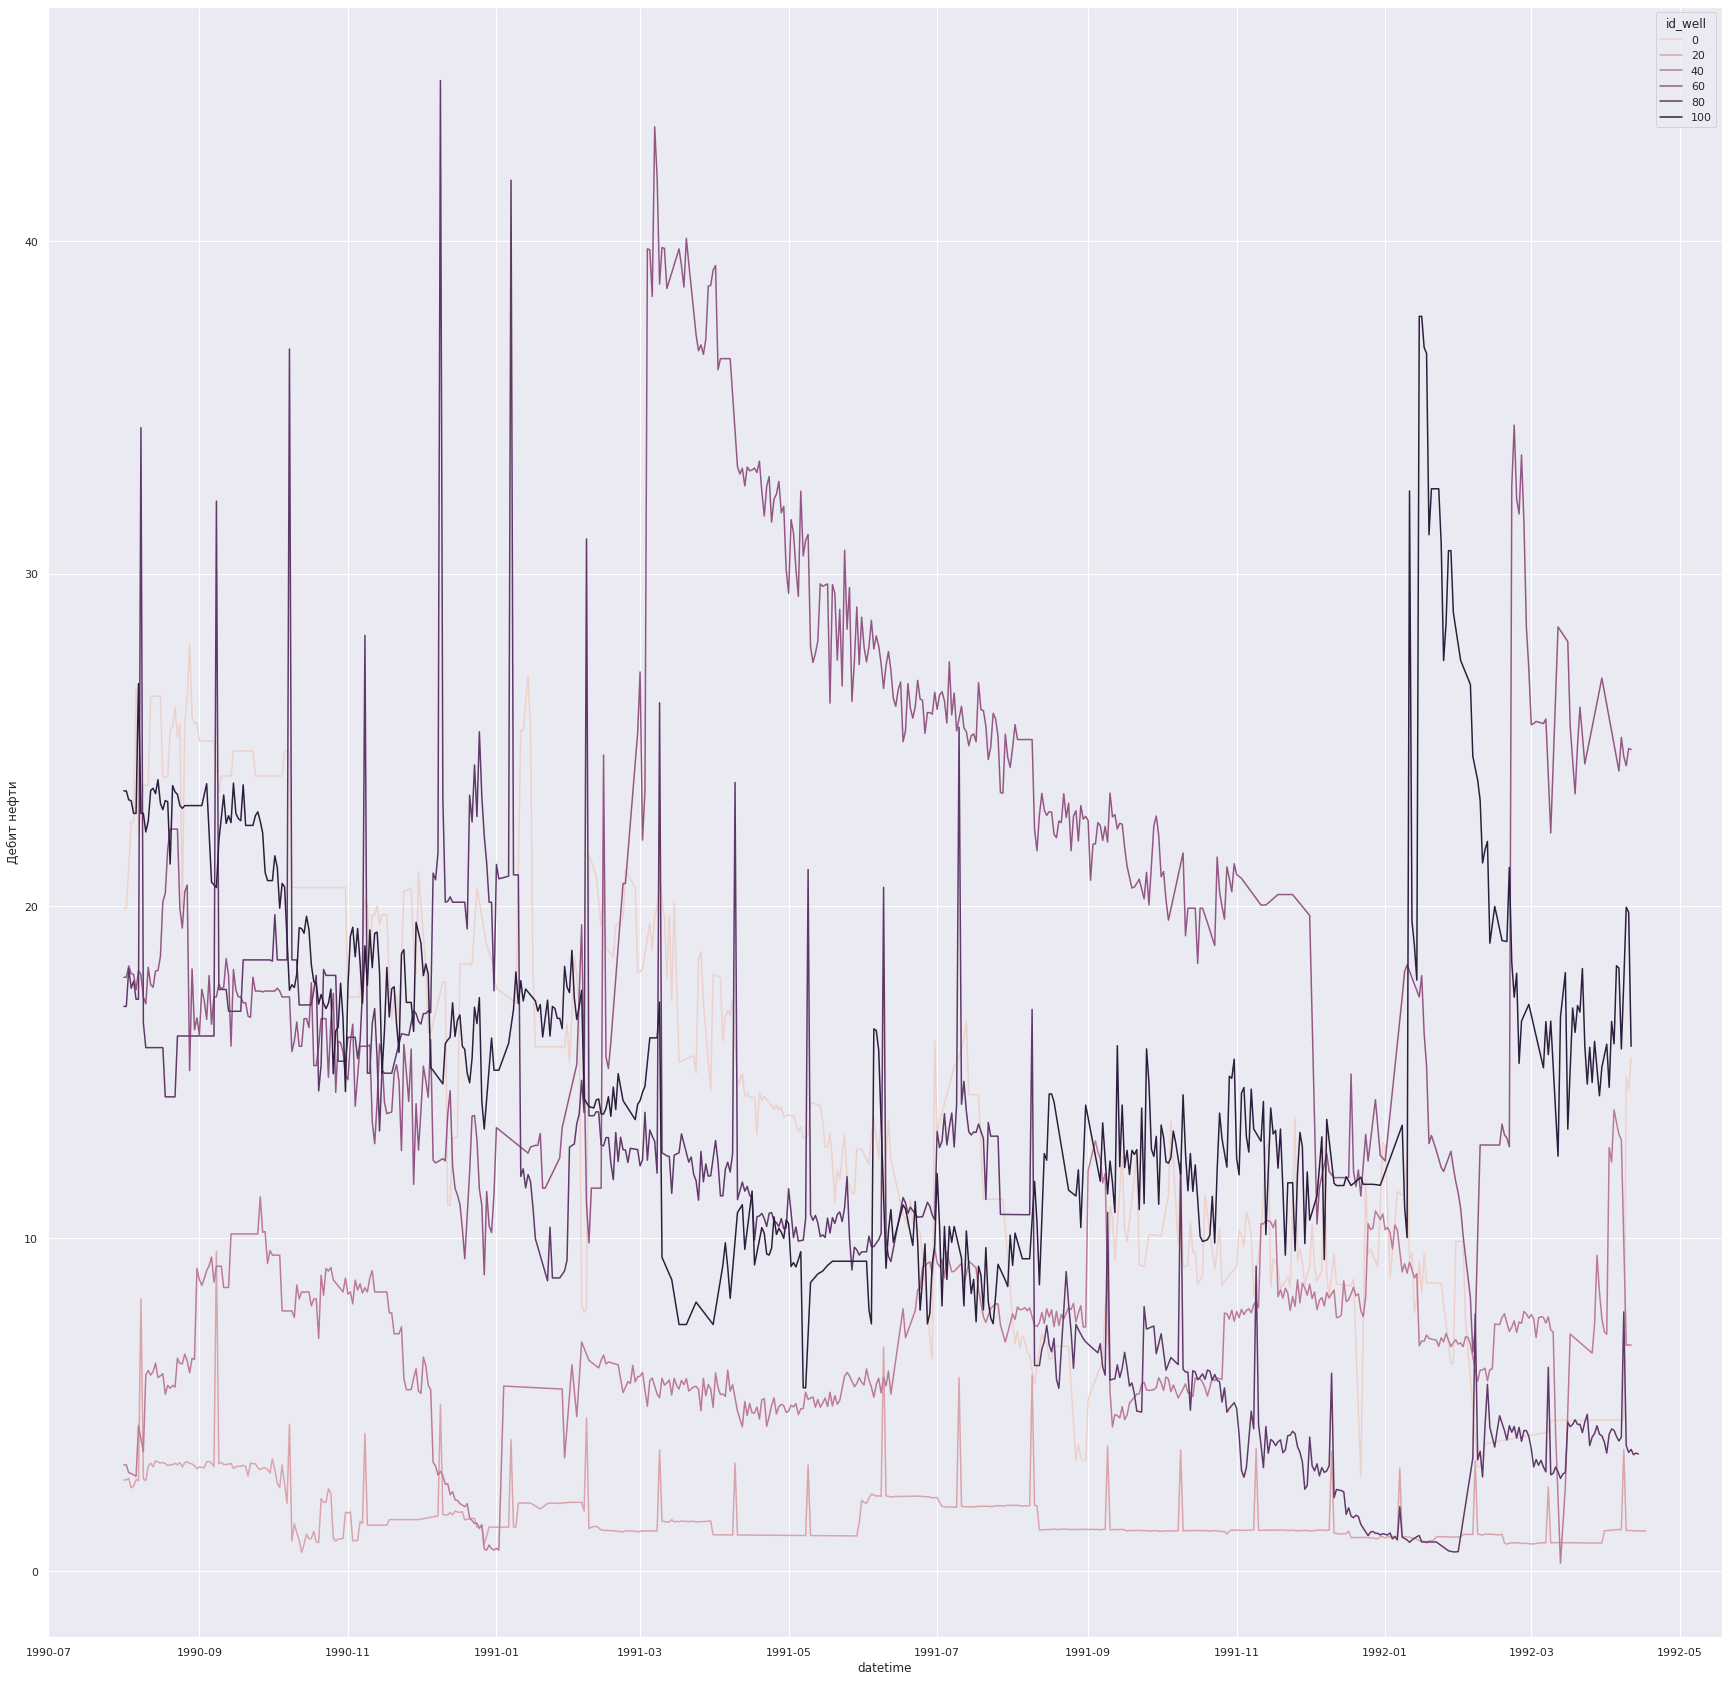

In [ ]:
sns.set(rc={'figure.figsize':(30,30)})
sns.lineplot(data=feature[feature['id_well'] % 20 == 0], x='datetime', y='Дебит нефти', hue='id_well')

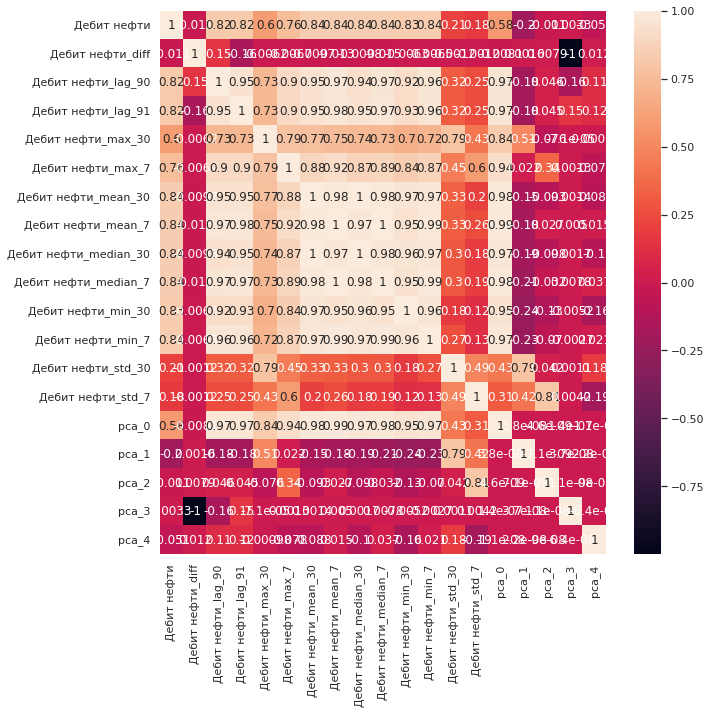

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(feature.corr(), annot = True)

In [ ]:
temp = feature.reset_index()
temp = temp[temp['Номер скважины'] == 0][['datetime', 'Дебит нефти', 'Активная мощность (ТМ)_lag_90', 'Время работы (ТМ)_lag_90', 'Давление буферное_lag_90',
       'Давление забойное от Hд_lag_90', 'Давление забойное от Pпр_lag_90',
       'Давление забойное_lag_90', 'Давление линейное (ТМ)_lag_90',
       'Давление на входе ЭЦН (ТМ)_lag_90',
       'Дебит газа попутного_lag_90', 'Дебит жидкости (ТМ)_lag_90',
       'Дебит нефти', 'Дебит нефти_lag_90', 'Дебит нефти_lag_91',
       'Коэффициент мощности (ТМ)_lag_90', 'Объем жидкости_lag_90',
       'Объем нефти_lag_90']]
temp.plot(x='datetime')

KeyError: ignored

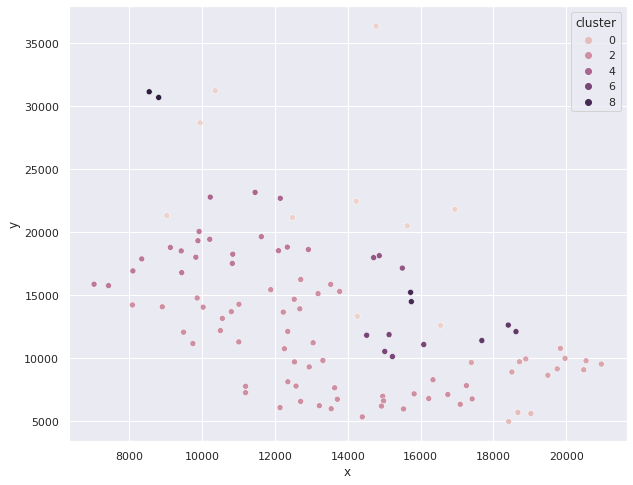

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(data=map, x='x', y='y', hue='cluster')

# CV

In [ ]:
dates_time_split = ['1990-12-13','1991-04-13','1991-07-13','1991-10-13','1992-01-13']

  0%|          | 0/5 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.98892
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.92141
[3]	valid_0's rmse: 8.85395
[4]	valid_0's rmse: 8.78772
[5]	valid_0's rmse: 8.72236
[6]	valid_0's rmse: 8.65883
[7]	valid_0's rmse: 8.59535
[8]	valid_0's rmse: 8.53245
[9]	valid_0's rmse: 8.47057
[10]	valid_0's rmse: 8.41
[11]	valid_0's rmse: 8.34959
[12]	valid_0's rmse: 8.29072
[13]	valid_0's rmse: 8.23321
[14]	valid_0's rmse: 8.17475
[15]	valid_0's rmse: 8.11781
[16]	valid_0's rmse: 8.06134
[17]	valid_0's rmse: 8.0065
[18]	valid_0's rmse: 7.95201
[19]	valid_0's rmse: 7.89894
[20]	valid_0's rmse: 7.84577
[21]	valid_0's rmse: 7.79421
[22]	valid_0's rmse: 7.74396
[23]	valid_0's rmse: 7.6933
[24]	valid_0's rmse: 7.64224
[25]	valid_0's rmse: 7.59252
[26]	valid_0's rmse: 7.5449
[27]	valid_0's rmse: 7.49666
[28]	valid_0's rmse: 7.44994
[29]	valid_0's rmse: 7.40305
[30]	valid_0's rmse: 7.35636
[31]	valid_0's rmse: 7.31145
[32]	valid_0's rmse: 7.26649
[33]	valid_0's rmse: 7.22


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.98903
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.92076
[3]	valid_0's rmse: 8.85361
[4]	valid_0's rmse: 8.78856
[5]	valid_0's rmse: 8.7234
[6]	valid_0's rmse: 8.65764
[7]	valid_0's rmse: 8.59516
[8]	valid_0's rmse: 8.5339
[9]	valid_0's rmse: 8.47203
[10]	valid_0's rmse: 8.41132
[11]	valid_0's rmse: 8.35011
[12]	valid_0's rmse: 8.29192
[13]	valid_0's rmse: 8.23302
[14]	valid_0's rmse: 8.17519
[15]	valid_0's rmse: 8.11826
[16]	valid_0's rmse: 8.06191
[17]	valid_0's rmse: 8.00701
[18]	valid_0's rmse: 7.95199
[19]	valid_0's rmse: 7.89801
[20]	valid_0's rmse: 7.84587
[21]	valid_0's rmse: 7.79315
[22]	valid_0's rmse: 7.74163
[23]	valid_0's rmse: 7.69186
[24]	valid_0's rmse: 7.64152
[25]	valid_0's rmse: 7.59211
[26]	valid_0's rmse: 7.54364
[27]	valid_0's rmse: 7.49552
[28]	valid_0's rmse: 7.44805
[29]	valid_0's rmse: 7.40097
[30]	valid_0's rmse: 7.35438
[31]	valid_0's rmse: 7.30833
[32]	valid_0's rmse: 7.2643
[33]	valid_0's rmse: 7


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.98718
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.91889
[3]	valid_0's rmse: 8.8519
[4]	valid_0's rmse: 8.78558
[5]	valid_0's rmse: 8.72069
[6]	valid_0's rmse: 8.6566
[7]	valid_0's rmse: 8.59458
[8]	valid_0's rmse: 8.53218
[9]	valid_0's rmse: 8.47246
[10]	valid_0's rmse: 8.4127
[11]	valid_0's rmse: 8.35299
[12]	valid_0's rmse: 8.29461
[13]	valid_0's rmse: 8.2374
[14]	valid_0's rmse: 8.18157
[15]	valid_0's rmse: 8.12497
[16]	valid_0's rmse: 8.0691
[17]	valid_0's rmse: 8.01312
[18]	valid_0's rmse: 7.95834
[19]	valid_0's rmse: 7.90579
[20]	valid_0's rmse: 7.85354
[21]	valid_0's rmse: 7.80097
[22]	valid_0's rmse: 7.74926
[23]	valid_0's rmse: 7.69924
[24]	valid_0's rmse: 7.64879
[25]	valid_0's rmse: 7.59883
[26]	valid_0's rmse: 7.54996
[27]	valid_0's rmse: 7.50174
[28]	valid_0's rmse: 7.45453
[29]	valid_0's rmse: 7.40767
[30]	valid_0's rmse: 7.36238
[31]	valid_0's rmse: 7.31679
[32]	valid_0's rmse: 7.27313
[33]	valid_0's rmse: 7.2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 20%|██        | 1/5 [00:13<00:54, 13.54s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.35395
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.28873
[3]	valid_0's rmse: 8.22346
[4]	valid_0's rmse: 8.1607
[5]	valid_0's rmse: 8.09695
[6]	valid_0's rmse: 8.03435
[7]	valid_0's rmse: 7.97258
[8]	valid_0's rmse: 7.91254
[9]	valid_0's rmse: 7.85441
[10]	valid_0's rmse: 7.79512
[11]	valid_0's rmse: 7.73548
[12]	valid_0's rmse: 7.67885
[13]	valid_0's rmse: 7.62171
[14]	valid_0's rmse: 7.56317
[15]	valid_0's rmse: 7.50793
[16]	valid_0's rmse: 7.45346
[17]	valid_0's rmse: 7.39951
[18]	valid_0's rmse: 7.34507
[19]	valid_0's rmse: 7.29358
[20]	valid_0's rmse: 7.2415
[21]	valid_0's rmse: 7.19197
[22]	valid_0's rmse: 7.14209
[23]	valid_0's rmse: 7.09304
[24]	valid_0's rmse: 7.0441
[25]	valid_0's rmse: 6.99753
[26]	valid_0's rmse: 6.94955
[27]	valid_0's rmse: 6.90383
[28]	valid_0's rmse: 6.85864
[29]	valid_0's rmse: 6.81258
[30]	valid_0's rmse: 6.76801
[31]	valid_0's rmse: 6.72415
[32]	valid_0's rmse: 6.68079
[33]	valid_0's rmse: 6


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.3553
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.28755
[3]	valid_0's rmse: 8.22398
[4]	valid_0's rmse: 8.15962
[5]	valid_0's rmse: 8.09468
[6]	valid_0's rmse: 8.03228
[7]	valid_0's rmse: 7.97107
[8]	valid_0's rmse: 7.91024
[9]	valid_0's rmse: 7.84975
[10]	valid_0's rmse: 7.79137
[11]	valid_0's rmse: 7.73313
[12]	valid_0's rmse: 7.67427
[13]	valid_0's rmse: 7.61767
[14]	valid_0's rmse: 7.55976
[15]	valid_0's rmse: 7.50664
[16]	valid_0's rmse: 7.4515
[17]	valid_0's rmse: 7.3981
[18]	valid_0's rmse: 7.34527
[19]	valid_0's rmse: 7.29237
[20]	valid_0's rmse: 7.24219
[21]	valid_0's rmse: 7.1912
[22]	valid_0's rmse: 7.14246
[23]	valid_0's rmse: 7.09435
[24]	valid_0's rmse: 7.04665
[25]	valid_0's rmse: 7.00008
[26]	valid_0's rmse: 6.95351
[27]	valid_0's rmse: 6.90581
[28]	valid_0's rmse: 6.85984
[29]	valid_0's rmse: 6.81511
[30]	valid_0's rmse: 6.77145
[31]	valid_0's rmse: 6.72771
[32]	valid_0's rmse: 6.68497
[33]	valid_0's rmse: 6.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 8.35585
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 8.28992
[3]	valid_0's rmse: 8.22276
[4]	valid_0's rmse: 8.15882
[5]	valid_0's rmse: 8.09608
[6]	valid_0's rmse: 8.03431
[7]	valid_0's rmse: 7.97329
[8]	valid_0's rmse: 7.91401
[9]	valid_0's rmse: 7.8553
[10]	valid_0's rmse: 7.79689
[11]	valid_0's rmse: 7.73857
[12]	valid_0's rmse: 7.68074
[13]	valid_0's rmse: 7.62594
[14]	valid_0's rmse: 7.5712
[15]	valid_0's rmse: 7.51774
[16]	valid_0's rmse: 7.46239
[17]	valid_0's rmse: 7.40887
[18]	valid_0's rmse: 7.35474
[19]	valid_0's rmse: 7.30093
[20]	valid_0's rmse: 7.25037
[21]	valid_0's rmse: 7.19938
[22]	valid_0's rmse: 7.14873
[23]	valid_0's rmse: 7.09926
[24]	valid_0's rmse: 7.05209
[25]	valid_0's rmse: 7.00299
[26]	valid_0's rmse: 6.95589
[27]	valid_0's rmse: 6.91114
[28]	valid_0's rmse: 6.866
[29]	valid_0's rmse: 6.82368
[30]	valid_0's rmse: 6.77949
[31]	valid_0's rmse: 6.73605
[32]	valid_0's rmse: 6.69404
[33]	valid_0's rmse: 6.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 40%|████      | 2/5 [00:24<00:35, 11.94s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.90334
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.83752
[3]	valid_0's rmse: 7.77383
[4]	valid_0's rmse: 7.70994
[5]	valid_0's rmse: 7.65203
[6]	valid_0's rmse: 7.58972
[7]	valid_0's rmse: 7.52998
[8]	valid_0's rmse: 7.47005
[9]	valid_0's rmse: 7.41135
[10]	valid_0's rmse: 7.35299
[11]	valid_0's rmse: 7.29582
[12]	valid_0's rmse: 7.23975
[13]	valid_0's rmse: 7.1828
[14]	valid_0's rmse: 7.12683
[15]	valid_0's rmse: 7.07159
[16]	valid_0's rmse: 7.01885
[17]	valid_0's rmse: 6.96524
[18]	valid_0's rmse: 6.91388
[19]	valid_0's rmse: 6.8623
[20]	valid_0's rmse: 6.8115
[21]	valid_0's rmse: 6.7624
[22]	valid_0's rmse: 6.71373
[23]	valid_0's rmse: 6.66538
[24]	valid_0's rmse: 6.62121
[25]	valid_0's rmse: 6.57432
[26]	valid_0's rmse: 6.52755
[27]	valid_0's rmse: 6.48215
[28]	valid_0's rmse: 6.43695
[29]	valid_0's rmse: 6.39265
[30]	valid_0's rmse: 6.34882
[31]	valid_0's rmse: 6.30752
[32]	valid_0's rmse: 6.26466
[33]	valid_0's rmse: 6.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.90199
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.83677
[3]	valid_0's rmse: 7.77228
[4]	valid_0's rmse: 7.70878
[5]	valid_0's rmse: 7.64954
[6]	valid_0's rmse: 7.58746
[7]	valid_0's rmse: 7.5276
[8]	valid_0's rmse: 7.46777
[9]	valid_0's rmse: 7.41268
[10]	valid_0's rmse: 7.35407
[11]	valid_0's rmse: 7.29544
[12]	valid_0's rmse: 7.23867
[13]	valid_0's rmse: 7.1824
[14]	valid_0's rmse: 7.12758
[15]	valid_0's rmse: 7.07363
[16]	valid_0's rmse: 7.01961
[17]	valid_0's rmse: 6.96785
[18]	valid_0's rmse: 6.91511
[19]	valid_0's rmse: 6.86377
[20]	valid_0's rmse: 6.81382
[21]	valid_0's rmse: 6.7647
[22]	valid_0's rmse: 6.71643
[23]	valid_0's rmse: 6.66929
[24]	valid_0's rmse: 6.62176
[25]	valid_0's rmse: 6.57464
[26]	valid_0's rmse: 6.5287
[27]	valid_0's rmse: 6.48374
[28]	valid_0's rmse: 6.43846
[29]	valid_0's rmse: 6.394
[30]	valid_0's rmse: 6.35114
[31]	valid_0's rmse: 6.31127
[32]	valid_0's rmse: 6.26865
[33]	valid_0's rmse: 6.22


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.90274
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.84169
[3]	valid_0's rmse: 7.77684
[4]	valid_0's rmse: 7.71393
[5]	valid_0's rmse: 7.65219
[6]	valid_0's rmse: 7.5902
[7]	valid_0's rmse: 7.53019
[8]	valid_0's rmse: 7.46961
[9]	valid_0's rmse: 7.41155
[10]	valid_0's rmse: 7.35343
[11]	valid_0's rmse: 7.29612
[12]	valid_0's rmse: 7.23834
[13]	valid_0's rmse: 7.18297
[14]	valid_0's rmse: 7.12895
[15]	valid_0's rmse: 7.07542
[16]	valid_0's rmse: 7.02224
[17]	valid_0's rmse: 6.96958
[18]	valid_0's rmse: 6.91776
[19]	valid_0's rmse: 6.86671
[20]	valid_0's rmse: 6.8166
[21]	valid_0's rmse: 6.76743
[22]	valid_0's rmse: 6.71761
[23]	valid_0's rmse: 6.66945
[24]	valid_0's rmse: 6.62182
[25]	valid_0's rmse: 6.57791
[26]	valid_0's rmse: 6.53209
[27]	valid_0's rmse: 6.48632
[28]	valid_0's rmse: 6.44124
[29]	valid_0's rmse: 6.39646
[30]	valid_0's rmse: 6.35278
[31]	valid_0's rmse: 6.31046
[32]	valid_0's rmse: 6.27061
[33]	valid_0's rmse: 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 60%|██████    | 3/5 [00:34<00:22, 11.30s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.55297
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.4917
[3]	valid_0's rmse: 7.43123
[4]	valid_0's rmse: 7.37127
[5]	valid_0's rmse: 7.31194
[6]	valid_0's rmse: 7.25319
[7]	valid_0's rmse: 7.19543
[8]	valid_0's rmse: 7.13888
[9]	valid_0's rmse: 7.08185
[10]	valid_0's rmse: 7.02695
[11]	valid_0's rmse: 6.97289
[12]	valid_0's rmse: 6.92
[13]	valid_0's rmse: 6.86782
[14]	valid_0's rmse: 6.81697
[15]	valid_0's rmse: 6.76569
[16]	valid_0's rmse: 6.71448
[17]	valid_0's rmse: 6.66399
[18]	valid_0's rmse: 6.61458
[19]	valid_0's rmse: 6.56666
[20]	valid_0's rmse: 6.51858
[21]	valid_0's rmse: 6.47302
[22]	valid_0's rmse: 6.42751
[23]	valid_0's rmse: 6.38064
[24]	valid_0's rmse: 6.33544
[25]	valid_0's rmse: 6.2908
[26]	valid_0's rmse: 6.24664
[27]	valid_0's rmse: 6.20331
[28]	valid_0's rmse: 6.16061
[29]	valid_0's rmse: 6.11937
[30]	valid_0's rmse: 6.08309
[31]	valid_0's rmse: 6.04196
[32]	valid_0's rmse: 6.00098
[33]	valid_0's rmse: 5.9


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.55334
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.49143
[3]	valid_0's rmse: 7.43048
[4]	valid_0's rmse: 7.36975
[5]	valid_0's rmse: 7.3113
[6]	valid_0's rmse: 7.25342
[7]	valid_0's rmse: 7.1954
[8]	valid_0's rmse: 7.13803
[9]	valid_0's rmse: 7.08182
[10]	valid_0's rmse: 7.02815
[11]	valid_0's rmse: 6.97406
[12]	valid_0's rmse: 6.92059
[13]	valid_0's rmse: 6.86698
[14]	valid_0's rmse: 6.81461
[15]	valid_0's rmse: 6.76283
[16]	valid_0's rmse: 6.71045
[17]	valid_0's rmse: 6.66139
[18]	valid_0's rmse: 6.61182
[19]	valid_0's rmse: 6.5634
[20]	valid_0's rmse: 6.51523
[21]	valid_0's rmse: 6.46845
[22]	valid_0's rmse: 6.4241
[23]	valid_0's rmse: 6.37928
[24]	valid_0's rmse: 6.33413
[25]	valid_0's rmse: 6.28925
[26]	valid_0's rmse: 6.24602
[27]	valid_0's rmse: 6.20136
[28]	valid_0's rmse: 6.15866
[29]	valid_0's rmse: 6.11741
[30]	valid_0's rmse: 6.07581
[31]	valid_0's rmse: 6.03697
[32]	valid_0's rmse: 5.99768
[33]	valid_0's rmse: 5.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.56268
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.50112
[3]	valid_0's rmse: 7.44001
[4]	valid_0's rmse: 7.37928
[5]	valid_0's rmse: 7.32024
[6]	valid_0's rmse: 7.26107
[7]	valid_0's rmse: 7.20277
[8]	valid_0's rmse: 7.14567
[9]	valid_0's rmse: 7.09156
[10]	valid_0's rmse: 7.03759
[11]	valid_0's rmse: 6.98353
[12]	valid_0's rmse: 6.93093
[13]	valid_0's rmse: 6.87885
[14]	valid_0's rmse: 6.82598
[15]	valid_0's rmse: 6.77524
[16]	valid_0's rmse: 6.72421
[17]	valid_0's rmse: 6.6743
[18]	valid_0's rmse: 6.62487
[19]	valid_0's rmse: 6.57596
[20]	valid_0's rmse: 6.5278
[21]	valid_0's rmse: 6.47966
[22]	valid_0's rmse: 6.43233
[23]	valid_0's rmse: 6.38582
[24]	valid_0's rmse: 6.34007
[25]	valid_0's rmse: 6.29632
[26]	valid_0's rmse: 6.25377
[27]	valid_0's rmse: 6.21163
[28]	valid_0's rmse: 6.16847
[29]	valid_0's rmse: 6.12672
[30]	valid_0's rmse: 6.08636
[31]	valid_0's rmse: 6.04632
[32]	valid_0's rmse: 6.00578
[33]	valid_0's rmse: 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 80%|████████  | 4/5 [00:45<00:11, 11.03s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.19283
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.13831
[3]	valid_0's rmse: 7.08131
[4]	valid_0's rmse: 7.02962
[5]	valid_0's rmse: 6.97382
[6]	valid_0's rmse: 6.92225
[7]	valid_0's rmse: 6.87122
[8]	valid_0's rmse: 6.81896
[9]	valid_0's rmse: 6.76713
[10]	valid_0's rmse: 6.71503
[11]	valid_0's rmse: 6.66415
[12]	valid_0's rmse: 6.61382
[13]	valid_0's rmse: 6.56435
[14]	valid_0's rmse: 6.51566
[15]	valid_0's rmse: 6.4709
[16]	valid_0's rmse: 6.42538
[17]	valid_0's rmse: 6.3787
[18]	valid_0's rmse: 6.33677
[19]	valid_0's rmse: 6.29098
[20]	valid_0's rmse: 6.24688
[21]	valid_0's rmse: 6.20466
[22]	valid_0's rmse: 6.16249
[23]	valid_0's rmse: 6.12142
[24]	valid_0's rmse: 6.08087
[25]	valid_0's rmse: 6.04352
[26]	valid_0's rmse: 6.00469
[27]	valid_0's rmse: 5.96523
[28]	valid_0's rmse: 5.92667
[29]	valid_0's rmse: 5.89275
[30]	valid_0's rmse: 5.85621
[31]	valid_0's rmse: 5.81962
[32]	valid_0's rmse: 5.78378
[33]	valid_0's rmse: 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.18808
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.13036
[3]	valid_0's rmse: 7.07314
[4]	valid_0's rmse: 7.01726
[5]	valid_0's rmse: 6.9631
[6]	valid_0's rmse: 6.9097
[7]	valid_0's rmse: 6.85602
[8]	valid_0's rmse: 6.80339
[9]	valid_0's rmse: 6.752
[10]	valid_0's rmse: 6.70118
[11]	valid_0's rmse: 6.65423
[12]	valid_0's rmse: 6.60422
[13]	valid_0's rmse: 6.55426
[14]	valid_0's rmse: 6.50599
[15]	valid_0's rmse: 6.45832
[16]	valid_0's rmse: 6.41156
[17]	valid_0's rmse: 6.3689
[18]	valid_0's rmse: 6.32297
[19]	valid_0's rmse: 6.27896
[20]	valid_0's rmse: 6.23651
[21]	valid_0's rmse: 6.19295
[22]	valid_0's rmse: 6.15423
[23]	valid_0's rmse: 6.11684
[24]	valid_0's rmse: 6.07748
[25]	valid_0's rmse: 6.03676
[26]	valid_0's rmse: 5.99778
[27]	valid_0's rmse: 5.95826
[28]	valid_0's rmse: 5.92049
[29]	valid_0's rmse: 5.88617
[30]	valid_0's rmse: 5.84976
[31]	valid_0's rmse: 5.81569
[32]	valid_0's rmse: 5.78295
[33]	valid_0's rmse: 5.7


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's rmse: 7.18758
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 7.13053
[3]	valid_0's rmse: 7.07291
[4]	valid_0's rmse: 7.02098
[5]	valid_0's rmse: 6.96688
[6]	valid_0's rmse: 6.91187
[7]	valid_0's rmse: 6.85774
[8]	valid_0's rmse: 6.80801
[9]	valid_0's rmse: 6.75641
[10]	valid_0's rmse: 6.70963
[11]	valid_0's rmse: 6.66067
[12]	valid_0's rmse: 6.6142
[13]	valid_0's rmse: 6.56558
[14]	valid_0's rmse: 6.5177
[15]	valid_0's rmse: 6.47138
[16]	valid_0's rmse: 6.42512
[17]	valid_0's rmse: 6.37937
[18]	valid_0's rmse: 6.33337
[19]	valid_0's rmse: 6.28866
[20]	valid_0's rmse: 6.24509
[21]	valid_0's rmse: 6.20534
[22]	valid_0's rmse: 6.16588
[23]	valid_0's rmse: 6.12316
[24]	valid_0's rmse: 6.08493
[25]	valid_0's rmse: 6.04316
[26]	valid_0's rmse: 6.00367
[27]	valid_0's rmse: 5.96527
[28]	valid_0's rmse: 5.92884
[29]	valid_0's rmse: 5.89125
[30]	valid_0's rmse: 5.85511
[31]	valid_0's rmse: 5.82284
[32]	valid_0's rmse: 5.78892
[33]	valid_0's rmse: 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 5/5 [00:55<00:00, 11.05s/it]

[225]	valid_0's rmse: 4.35766
[226]	valid_0's rmse: 4.3574
[227]	valid_0's rmse: 4.35814
Early stopping, best iteration is:
[177]	valid_0's rmse: 4.33383
{'1990-12-13 SEED:69': 4.81843478880822, '1990-12-13 SEED:420': 4.818831716549382, '1990-12-13 SEED:0': 4.824457220601511, '1991-04-13 SEED:69': 4.431797612079345, '1991-04-13 SEED:420': 4.431715630959549, '1991-04-13 SEED:0': 4.437036438745021, '1991-07-13 SEED:69': 4.1616882391026495, '1991-07-13 SEED:420': 4.162593949700352, '1991-07-13 SEED:0': 4.171271910963812, '1991-10-13 SEED:69': 4.06718139704389, '1991-10-13 SEED:420': 4.072286473474673, '1991-10-13 SEED:0': 4.0631083265425785, '1992-01-13 SEED:69': 4.331128525046285, '1992-01-13 SEED:420': 4.324632728520314, '1992-01-13 SEED:0': 4.333830372054456}
Mean RMSE : 4.363333022012801


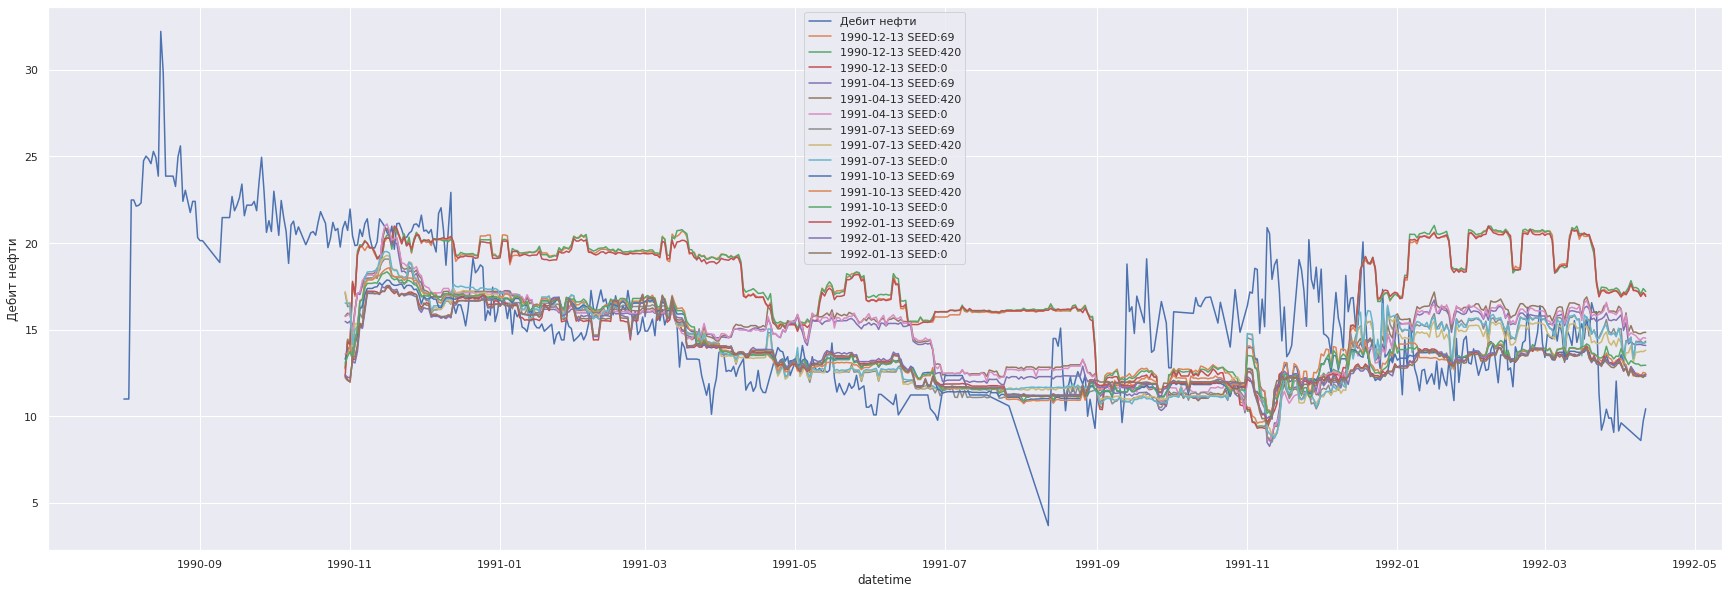

In [ ]:
index = 1
metrics = {}
#Mean RMSE : 4.870786509912366 - id, time, lag+oil, mean, day
#Mean RMSE : 4.828861779044985 - Процент нефти, Полная мощность, Разность давления забойного и входа
#Mean RMSE : 4.716022191230724 - Процент дебита попутного газа к нефте, Продуктивность (Дебит нефти к давлению забойному), Продуктивность (Дебит нефти к разности забойного и входа)
#Mean RMSE : 4.595859486867411 - без 'Продуктивность (Дебит нефти к давлению линейному)'
#Mean RMSE : 4.4056785176824445

sns.set(rc={'figure.figsize':(30,10)})
sns.lineplot(data=oil_table[oil_table['Номер скважины'] == index], x='datetime', y='Дебит нефти', label='Дебит нефти')

for date in tqdm(dates_time_split):
  X_train = X.iloc[X.index.get_level_values('datetime') < date]
  X_test = X.iloc[X.index.get_level_values('datetime') >= date]
  y_train = y.iloc[y.index.get_level_values('datetime') < date]
  y_test = y.iloc[y.index.get_level_values('datetime') >= date]

  for seed in [69, 420, 0]:
    model = lgb.LGBMRegressor(num_iterations=300, num_leaves=30, feature_fraction=0.8, learning_rate=.01, early_stopping_round=50, metric='rmse', random_state=seed)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    metrics.update({f'{date} SEED:{seed}': mean_squared_error(y_test, model.predict(X_test), squared=False)})
    show_data = feature_train.iloc[feature_train.index.get_level_values('Номер скважины') == index]
    show_data['prediction'] = model.predict(X.iloc[X.index.get_level_values('Номер скважины') == index])
    show_data.index = show_data.index.droplevel(1)
    sns.lineplot(data=show_data, x='datetime', y='prediction', label=f'{date} SEED:{seed}')

print(metrics)
print(f'Mean RMSE : {sum(metrics.values())/len(metrics)}')

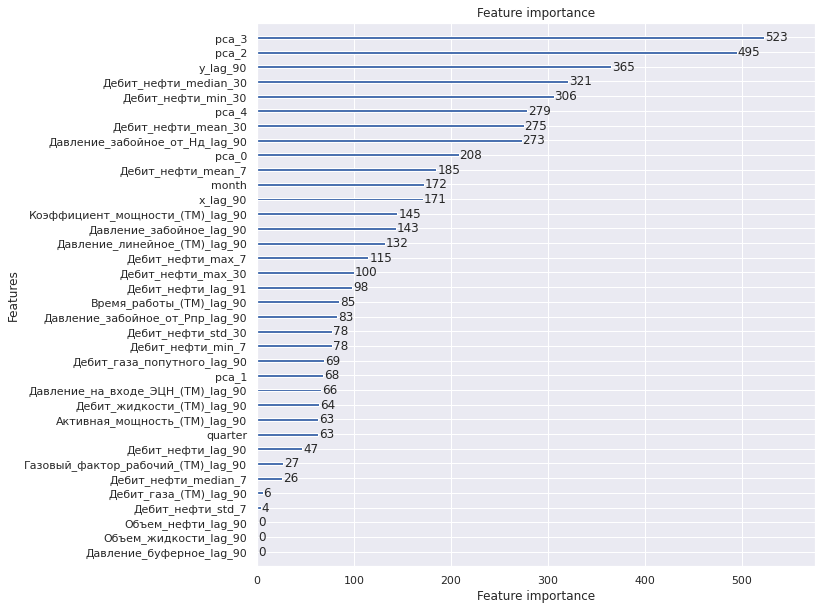

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
lgb.plot_importance(model, ignore_zero=False)

In [ ]:
def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p-1), dtype=np.float)
    for i in range(p-1):
        idx = np.ones(p, dtype=bool)
        idx[i] = False
        idx[p-1] = False
        beta_i = linalg.lstsq(C[:, idx], C[:, i])[0]
        beta_j = linalg.lstsq(C[:, idx], C[:, p-1])[0]

        res_j = C[:, p-1] - C[:, idx].dot(beta_i)
        res_i = C[:, i] - C[:, idx].dot(beta_j)
            
        corr = stats.pearsonr(res_i, res_j)[0]
        P_corr[i] = corr
        
    return P_corr

In [ ]:
shap_values_train = shap.TreeExplainer(model).shap_values(X_train)
shap_values_test = shap.TreeExplainer(model).shap_values(X_test)

In [ ]:
corr_train = partial_corr(np.hstack((shap_values_train, y_train.to_numpy().reshape(-1, 1))))
corr_test = partial_corr(np.hstack((shap_values_test, y_test.to_numpy().reshape(-1, 1))))

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


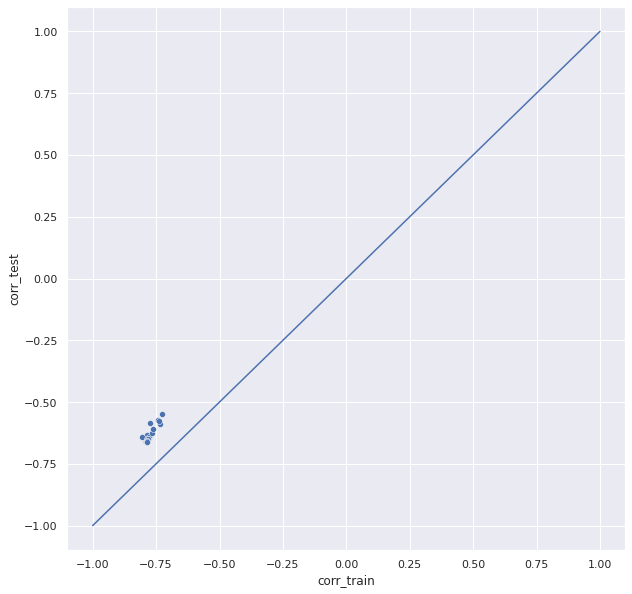

In [ ]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,10)})
temp = pd.DataFrame({'corr_train':corr_train, 'corr_test':corr_test, 'feature':X_train.columns.to_list()})
ax = sns.scatterplot(data=temp, x='corr_train', y='corr_test')
ax.plot([-1, 1], [-1, 1])

In [ ]:
sorted(temp.groupby('feature').apply(lambda x: x.corr_test - x.corr_train).to_dict().items(), key=lambda x: x[1], reverse=True)

[(('pca_2', 33), 0.1883759110851022),
 (('Дебит нефти_min_30', 24), 0.17956306681456113),
 (('Дебит нефти_mean_7', 21), 0.16752815205220584),
 (('Дебит нефти_median_30', 22), 0.16373273270757427),
 (('Дебит нефти_max_30', 18), 0.16057993042307694),
 (('quarter', 1), 0.1556671711697134),
 (('Дебит нефти_min_7', 25), 0.1537698115396745),
 (('Дебит нефти_mean_30', 20), 0.1486899620667994),
 (('Дебит нефти_lag_91', 17), 0.14018394334941064),
 (('Дебит нефти_median_7', 23), 0.13580693347663741),
 (('y_lag_90', 3), 0.1354739078455217),
 (('Дебит нефти_max_7', 19), 0.1343179926163911),
 (('Активная мощность (ТМ)_lag_90', 4), 0.13188544820795645),
 (('Дебит нефти_lag_90', 16), 0.1312263469677345),
 (('pca_0', 31), 0.13117443681268082),
 (('Давление забойное от Hд_lag_90', 8), 0.13099618294132265),
 (('Время работы (ТМ)_lag_90', 5), 0.13009565769170062),
 (('Давление линейное (ТМ)_lag_90', 11), 0.1300330723170101),
 (('x_lag_90', 2), 0.12982760790271808),
 (('pca_3', 34), 0.12893712132468993),


# Submission

In [ ]:
models = list()
for seed in [69, 420, 0]:
  model = lgb.LGBMRegressor(num_iterations=40, num_leaves=30, learning_rate=.05, metric='rmse', random_state=seed)
  model.fit(feature.dropna(subset=['Дебит нефти']).drop('Дебит нефти', axis=1), feature.dropna(subset=['Дебит нефти'])['Дебит нефти'])
  models.append(model)

Found `num_iterations` in params. Will use it instead of argument


In [ ]:
model = lgb.LGBMRegressor(num_iterations=150, num_leaves=30, learning_rate=.05, metric='rmse', random_state=420)
model.fit(feature.dropna(subset=['Дебит нефти']).drop('Дебит нефти', axis=1), feature.dropna(subset=['Дебит нефти'])['Дебит нефти'])

Found `num_iterations` in params. Will use it instead of argument


LGBMRegressor(learning_rate=0.05, metric='rmse', num_iterations=150,
              num_leaves=30, random_state=420)

In [ ]:
feature_test = deepcopy(feature)

#for i in range(3):
#  feature_test[f'forecast_{i}'] = models[i].predict(feature.drop('Дебит нефти', axis=1))

#feature_test['forecast'] = feature_test[[f'forecast_{i}' for i in range(3)]].mean(axis=1)
feature_test['forecast'] = model.predict(feature.drop('Дебит нефти', axis=1))
feature_test = feature_test.iloc[feature_test.index.get_level_values('datetime') >= '1992-04-11']
feature_test = feature_test.forecast.reset_index()[['datetime', 'forecast', 'Номер скважины']]

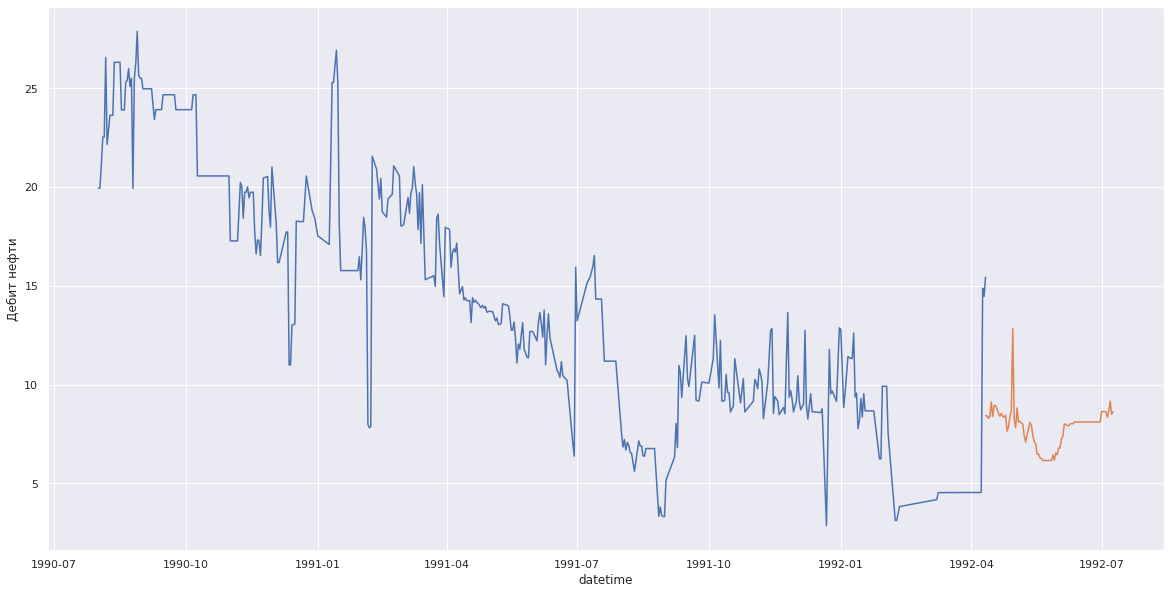

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=oil_table[oil_table['Номер скважины'] == 0], x='datetime', y='Дебит нефти')
sns.lineplot(data=feature_test[feature_test['Номер скважины'] == 0].reset_index(), x='datetime', y='forecast')

In [ ]:
feature_test.to_csv('submission.csv', index=None)